# Figure 2: basin sizes

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

sys.path.append("../code/")

from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [2]:
N = 83
nreps = 100
r= 2

seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [3]:
dfs = []

for seed in seeds:
    suf = f"ring_r_{r}_sym_seed_{seed}"  # "di"
    run_dir = f"{results_dir}run_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
    file_name = f"{run_dir}df_long_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"
    
    
    #run_dir = f"{results_dir}run_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
    #file_name = f"{run_dir}df_long_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"
    df_r = pd.read_csv(file_name, index_col=0)
    df_r["seed"] = seed

    dfs.append(df_r)
    

df = pd.concat(dfs)
df = df.reset_index()

In [4]:
df["q"] = df["state"].apply(lambda x: int(x[:-8]) if "twisted" in x else None)
df["k"] = df["state"].apply(lambda x: int(x[:-8]) if "cluster" in x else None)

df["state"] = df["state"].replace("sync", "0-twisted")

def agg_state(state):
    if "twisted" in state:
        return "twisted"
    elif "cluster" in state:
        return "cluster"
    elif state=="other":
        return "other"
    else:
        print(state, "?")

df["state agg."] = df["state"].apply(agg_state)

df

,index,k2,state,proba,seed,q,k,state agg.
0,0,0.00,0-twisted,1.00,1,0.0,NaN,twisted
1,1,0.25,0-twisted,0.91,1,0.0,NaN,twisted
2,2,0.50,0-twisted,0.06,1,0.0,NaN,twisted
3,3,0.75,0-twisted,NaN,1,0.0,NaN,twisted
4,4,1.00,0-twisted,NaN,1,0.0,NaN,twisted
...,...,...,...,...,...,...,...,...
1075,49,3.25,other,1.00,20,NaN,NaN,other
1076,50,3.50,other,1.00,20,NaN,NaN,other
1077,51,3.75,other,1.00,20,NaN,NaN,other
1078,52,4.00,other,1.00,20,NaN,NaN,other


In [5]:
mask_pos = (df["q"] >= 0) + (df["q"].isna())
mask_nobig = (98 < df["q"]) + (df["q"] < 4) + (df["q"].isna())
mask_twisted = df["state agg."] == "twisted"
mask_cluster = df["state agg."] == "cluster"
mask_other = df["state agg."] == "other"


df[mask_nobig].state.unique()

array(['0-twisted', '2-cluster', 'other'], dtype=object)

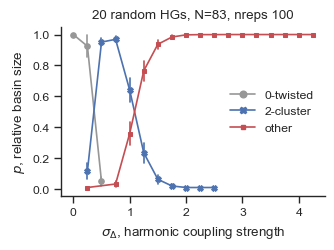

In [6]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
unique_states = sorted(
    [i for i in df[mask_pos * mask_nobig].state.unique() if "twisted" in i]
)

#df["state"] = df["state"].replace("other", "twisted 2-cluster")

labels = unique_states + ["2-cluster", "other"]

fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df, #[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["b", "r"],
    legend=True,
    ci="sd", err_style="bars"
)

#g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, harmonic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

sb.move_legend(g, loc="center right", bbox_to_anchor=(1, 0.5), frameon=False, title="")

#coupling_str = r"$\sigma \, \sin (\theta_j - \theta_i) + \sigma_{\Delta} \, \sin (2\theta_j - 2\theta_i)$"
#ax.set_title(coupling_str)

ax.set_title(f"{len(seeds)} random HGs, N={N}, nreps {nreps}")

# plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_2_{suf}.png", dpi=250, bbox_inches="tight", pad_inches=0.03)

## Linear stability

In [7]:
import xgi

In [8]:
HGs = []

for seed in seeds: 
    N= 83
    ps = 20 * np.array([1 / N, 1 / N**2])
    H = xgi.random_hypergraph(N, ps, seed=seed)
    
    HGs.append(H)

In [9]:
def compute_eigenvalues_multi(H, orders, weights, rescale_per_node=True):
    """Returns the Lyapunov exponents of corresponding to the muliotder Laplacian.

    Parameters
    ----------
    HG : xgi.HyperGraph
        Hypergraph
    orders : list of int
        Orders of interactions to consider.
    weights: list of float
        Weight of each order, i.e coupling strenghts gamma_i in [1]_.
    rescale_per_node: bool, (default=True)
        Whether to rescale each Laplacian of order d by d (per node).

    Returns
    -------
    lyap : array
        Array of dim (N,) with unsorted Lyapunov exponents
    """

    # compute multiorder Laplacian
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node
    )

    # compute eigenvalues
    eivals_multi, _ = np.linalg.eigh(L_multi)
    lyap_multi = -eivals_multi
    return lyap_multi

In [10]:
k2s = df["k2"].unique()
n_k2 = len(k2s)

lyaps_HG = np.zeros((n_k2, N, len(seeds)))

# compute Lyapunov exponents for all alpha values
for j, HG in enumerate(HGs):  # for all hypergraphs

    for i, k2 in enumerate(k2s):
        lyap_multi = compute_eigenvalues_multi(
            HG, orders=[1, 2], weights=[1, k2]
        )

        lyap_multi = np.sort(lyap_multi)[::-1]
        lyaps_HG[i, :, j] = lyap_multi

In [11]:
# average and std over the random realisations
# consider the second largest exponents only
means_HG = np.mean(lyaps_HG[:, 1, :], axis=1)
std_HG = np.std(lyaps_HG[:, 1, :], axis=1)

In [12]:
lyaps_HG[:, 1, :].shape

(18, 20)

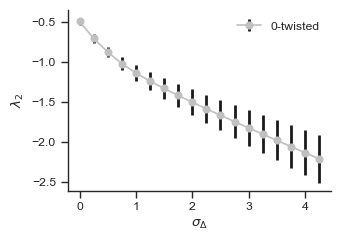

In [13]:
fig, ax = plt.subplots(figsize=(3.4, 2.35))

ax.errorbar(
    k2s,
    means_HG,
    yerr=std_HG,
    fmt="-o",
    color="silver",
    ecolor="k",
    elinewidth=2,
    capsize=0,
    label="0-twisted",
)


ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\sigma_{\Delta}$")

#ax.set_xticks([0, 0.5, 1])

sb.despine()
ax.legend(frameon=False)

fig_name = f"figure_1_lambda2_HG_SC_N_{N}_ps_{ps}"
#plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()

## Both

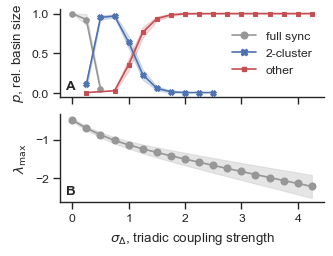

In [17]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
df["state"] = df["state"].replace("0-twisted", "full sync")


#unique_states = sorted(
#    [i for i in df[mask_pos * mask_nobig].state.unique() if "twisted" in i]
#)
unique_states = ["full sync"]

#df["state"] = df["state"].replace("other", "twisted 2-cluster")

#labels = unique_states + ["2-cluster", "other"]
labels = ["full sync", "2-cluster", "other"]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(3.4, 2.5), sharex=True)


g = sb.lineplot(
    data=df, #[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["b", "r"],
    legend=True,
    ci="sd", err_style="band"
)

#g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, harmonic coupling strength")
ax.set_ylabel("$p$, rel. basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

sb.move_legend(g, loc="center right", bbox_to_anchor=(1, 0.5), frameon=False, title="")

#coupling_str = r"$\sigma \, \sin (\theta_j - \theta_i) + \sigma_{\Delta} \, \sin (2\theta_j - 2\theta_i)$"
#ax.set_title(coupling_str)

ax2.errorbar(
    k2s,
    means_HG,
    yerr=std_HG,
    fmt="-o",
    color=sb.color_palette("Greys_r", n_colors=len(unique_states))[0],
    ecolor="k",
    elinewidth=0,
    capsize=0,
    label="full sync",
    
)

plt.fill_between(k2s, means_HG - std_HG, means_HG + std_HG, color="silver", alpha=0.4)


ax2.set_ylabel(r"$\lambda_{\rm max}$")
ax2.set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")

#ax.set_xticks([0, 0.5, 1])

sb.despine()
#ax2.legend(frameon=False)

#ax.set_title(f"{len(seeds)} random HGs, N={N}, nreps {nreps}")

ax.text(0.02, 0.05, "A", transform=ax.transAxes, va="bottom", ha="left", weight="bold")
ax2.text(0.02, 0.05, "B", transform=ax2.transAxes, va="bottom", ha="left", weight="bold")

plt.savefig(f"{results_dir}stability_randomHG.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}stability_randomHG.png", dpi=250, bbox_inches="tight", pad_inches=0.03)